Bu kod Google Drive-ni Google Colab bilan bog‘lash uchun ishlatiladi.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**TensorFlow** kutubxonasidan foydalanib, konvolyutsion neyron tarmog‘i (**CNN**) bilan ishlash

**Conv2D** → Konvolyutsion qatlam. Tasvirlardan muhim xususiyatlarni ajratib olish uchun ishlatiladi.

**MaxPooling2D** → Max-pooling operatsiyasi. Tasvir hajmini kichraytirib, muhim xususiyatlarni saqlab qolish uchun ishlatiladi.

**Dense** → Oddiy to‘liq bog‘langan neyron qatlam. CNN oxirida ishlatiladi.

**Dropout** → Overfitting (ortiqcha o‘rganish) oldini olish uchun neyronlarni tasodifiy o‘chirish.

**Flatten** → Konvolyutsion qatlam natijasini tekislaydi (matritsani vektorga o‘tkazadi).

In [ ]:
#Importing Libraries
import os # fayllarni o‘qish yoki yo‘llarni ko‘rsatish
import numpy as np #matritsalar, vektorlar
import tensorflow as tf #TensorFlow'ni tf qisqartmasi bilan ishlatamiz
from tensorflow.keras import layers #CNN va boshqa model qatlamlarini yaratish uchun ishlatiladi.
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator #Tasvirlarni yuklash va generatsiya qilish
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [ ]:
count = 0
dirs = os.listdir('/content/drive/MyDrive/Images')



for dir in dirs:
    dir_path = os.path.join('/content/drive/MyDrive/Images', dir)  # Full directory path
    if os.path.isdir(dir_path):  # Check if it's a directory
        files = list(os.listdir(dir_path))
        print(f'{dir} Folder has {len(files)} Images')
        count += len(files)

print(f'Images Folder has {count} Images')


daisy Folder has 764 Images
sunflower Folder has 733 Images
dandelion Folder has 1052 Images
tulip Folder has 984 Images
rose Folder has 784 Images
Images Folder has 4317 Images


In [ ]:
base_dir = '/content/drive/MyDrive/Images'  # rasmlar saqlangan papka manzili
img_size = 180 #CNN modeliga berish uchun rasmlar 180x180 ga o‘zgartiriladi.
batch = 32 #Har bir qadamda 32 ta rasm yuklanadi (mini-batch).

In [ ]:
#Train va Validation datasetlarni yaratish
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,  # Asosiy rasm papkasi
                                                       seed = 123, # random_state
                                                       validation_split=0.2, # Ma’lumotlarning 20% validation uchun ajratiladi
                                                       subset = 'training',  # faqat training
                                                       batch_size=batch,  # Har bir batch uchun 32 ta rasm yuklanadi
                                                       image_size=(img_size,img_size)) # Har bir rasm 180x180 o‘lchamga o‘zgartiriladi

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [ ]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
import matplotlib.pyplot as plt

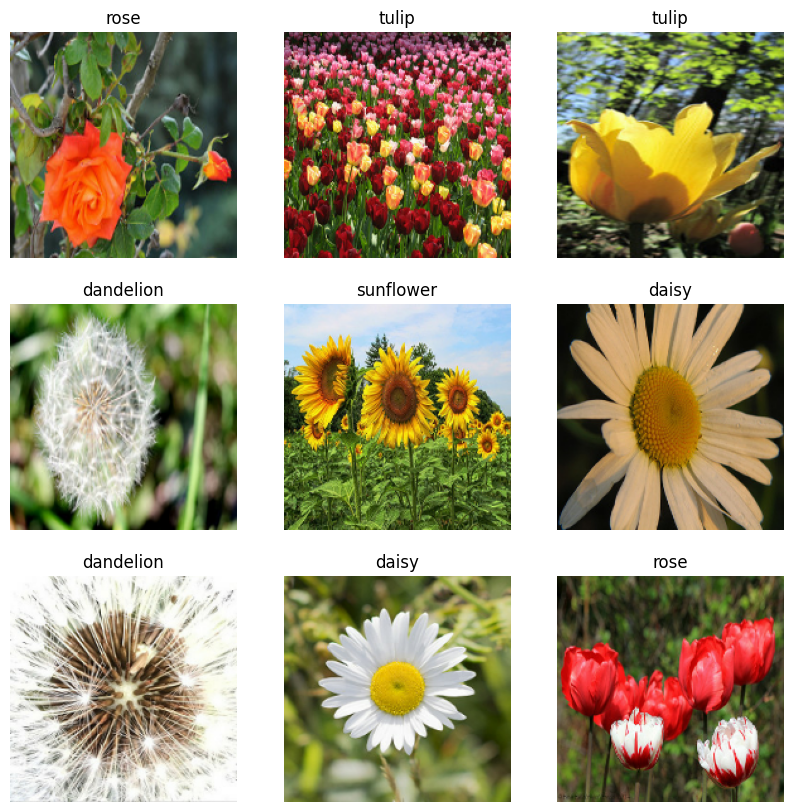

In [ ]:
# train dataset ichidagi tasvirlarni vizual ko‘rinishda ko‘rsatish
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):   #  train datasetda 1 ta batch
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')



# i = 0
# plt.figure(figsize=(10,10))

# for images, labels in train_ds.take(1):
#     for i in range(9):
#         images = data_augmentation(images)
#         plt.subplot(3,3, i+1)
#         plt.imshow(images[0].numpy().astype('uint8'))
#         plt.axis('off')

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE #dataset yuklanishini avtomatik optimallashtiradi.

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier

# # Pipeline yaratish
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),          # Avtomatik normalizatsiya
#     ('classifier', RandomForestClassifier(n_estimators=100, random_state=123))  # Model
# ])

# # Modelni o‘qitish
# pipeline.fit(X_train, y_train)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE) #Ma’lumotlarni Keshga Saqlash->RAM-> Epoch,  Ma’lumotlarni Oldindan Tayyorlash=prefetch

In [ ]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


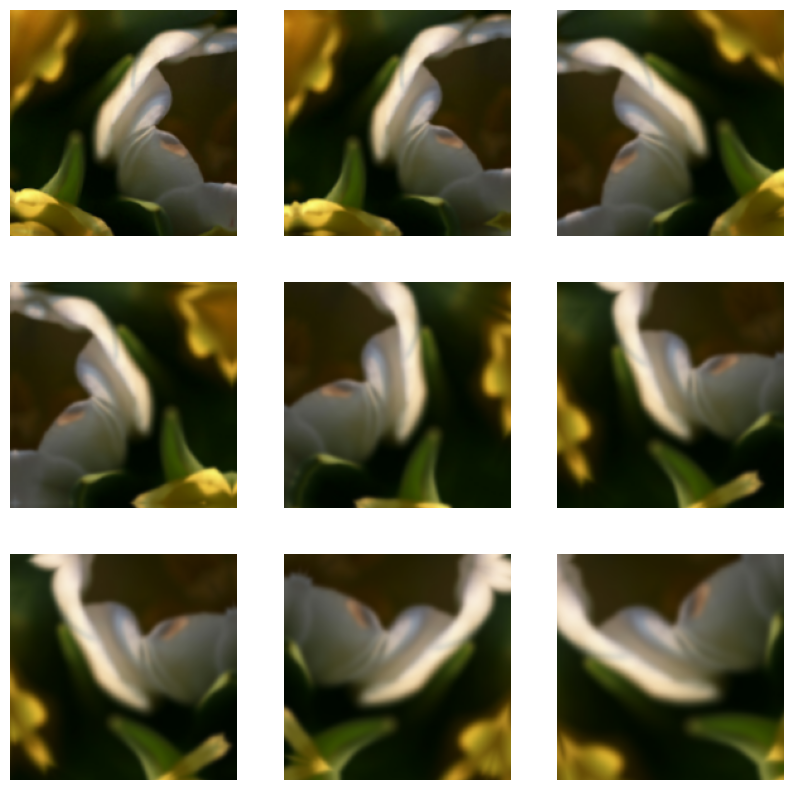

In [ ]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [ ]:
model = Sequential([
    data_augmentation, # Data augmentation (rasmni kengaytirish)
    layers.Rescaling(1./255), # Rasm piksellarini normallashtirish
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [ ]:
model.compile(optimizer='adam', #optimizatsiya algoritmi, ya'ni modelni trainda ishlatiladigan metod.
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #modelning xatolarini o'lchaydi.
              metrics=['accuracy']) #Modelni qanchalik yaxshi o‘rganganini bilish uchun accuracy metrikasidan foydalaniladi

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_ds, epochs=45, validation_data=val_ds)

Epoch 1/45
108/108 ━━━━━━━━━━━━━━━━━━━━ 97s 902ms/step - accuracy: 0.6584 - loss: 0.8855 - val_accuracy: 0.6616 - val_loss: 0.8810
Epoch 2/45
108/108 ━━━━━━━━━━━━━━━━━━━━ 98s 904ms/step - accuracy: 0.6866 - loss: 0.8231 - val_accuracy: 0.6860 - val_loss: 0.8032
Epoch 3/45
108/108 ━━━━━━━━━━━━━━━━━━━━ 96s 889ms/step - accuracy: 0.7188 - loss: 0.7586 - val_accuracy: 0.6895 - val_loss: 0.7651
Epoch 4/45
108/108 ━━━━━━━━━━━━━━━━━━━━ 98s 904ms/step - accuracy: 0.7167 - loss: 0.7441 - val_accuracy: 0.6918 - val_loss: 0.8162
Epoch 5/45
108/108 ━━━━━━━━━━━━━━━━━━━━ 96s 891ms/step - accuracy: 0.7236 - loss: 0.7051 - val_accuracy: 0.6987 - val_loss: 0.8028
Epoch 6/45
108/108 ━━━━━━━━━━━━━━━━━━━━ 95s 884ms/step - accuracy: 0.7430 - loss: 0.6787 - val_accuracy: 0.6686 - val_loss: 0.8750
Epoch 7/45
108/108 ━━━━━━━━━━━━━━━━━━━━ 96s 893ms/step - accuracy: 0.7407 - loss: 0.6836 - val_accuracy: 0.7289 - val_loss: 0.7250
Epoch 8/45
108/108 ━━━━━━━━━━━━━━━━━━━━ 96s 893ms/step - accuracy: 0.7635 - loss: 0

In [ ]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'Bu rasm tegishli ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
classify_images('/content/drive/MyDrive/Sample/Sample/rose.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


'Bu rasm tegishli rose with a score of 97.16089367866516'

In [ ]:
classify_images('/content/drive/MyDrive/Sample/Sample/daisy.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


'Bu rasm tegishli daisy with a score of 99.9998927116394'

In [ ]:
classify_images('/content/drive/MyDrive/Sample/Sample/tulip.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


'Bu rasm tegishli rose with a score of 99.97643828392029'

In [ ]:
classify_images('/content/drive/MyDrive/Sample/Sample/dandelion.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


'Bu rasm tegishli dandelion with a score of 99.98767375946045'

In [ ]:
classify_images('/content/drive/MyDrive/Sample/Sample/sunflower.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


'Bu rasm tegishli sunflower with a score of 99.91410970687866'

In [ ]:
model.save('Flower_Recog_Model.keras')

In [3]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [4]:
!git clone https://github.com/Sarvarbek1303/DL-projects.git

fatal: destination path 'DL-projects' already exists and is not an empty directory.
